# Исходные данные
    Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Восстановление золота из руды

Подготовка  модели машинного обучения для компании, разрабатывающей решения эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Решение поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

In [1]:
# Библиотеки

import math
import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor

from scipy import stats as st

from warnings import simplefilter 
simplefilter(action='ignore')

In [2]:
colours = ['#D0BBFF', '#FFFEA3'] 
def data_info(link, alt_link, data_name):
    try:
        data = pd.read_csv(alt_link)
    except:
        data = pd.read_csv(link)
   
    return data 

In [3]:
 full = data_info('/datasets/gold_industry_full.csv', 
                  'C:/Users/Ксения/data_analyst/добыча золота/gold_industry_full.csv','full')

In [4]:
 train = data_info('/datasets/gold_industry_train.csv', 
                   'C:/Users/Ксения/data_analyst/добыча золота/gold_industry_train.csv','train')

In [5]:
test = data_info('/datasets/gold_industry_test.csv', 
                 'C:/Users/Ксения/data_analyst/добыча золота/gold_industry_test.csv','test')

Пропуски full


date                        0
rougher.input.feed_au       0
rougher.input.feed_ag       0
rougher.input.feed_pb     100
rougher.input.feed_sol     99
                         ... 
final.output.recovery       0
final.output.tail_au        0
final.output.tail_ag        1
final.output.tail_pb      101
final.output.tail_sol       6
Length: 87, dtype: int64

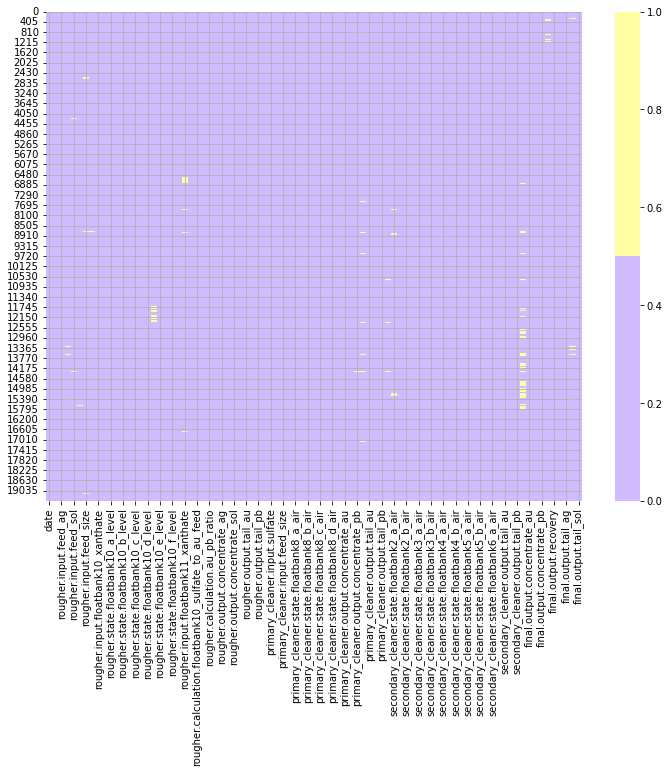

In [6]:
# Посмотрим на пропуски в датасетах
fig, ax = plt.subplots(figsize=(12,9))
print('Пропуски full')
sns.heatmap(full.isnull(), cmap=sns.color_palette(colours))
plt.grid()
full.isna().sum()

Пропуски train


date                       0
rougher.input.feed_au      0
rougher.input.feed_ag      0
rougher.input.feed_pb     72
rougher.input.feed_sol    77
                          ..
final.output.recovery      0
final.output.tail_au       0
final.output.tail_ag       1
final.output.tail_pb      75
final.output.tail_sol      5
Length: 87, dtype: int64

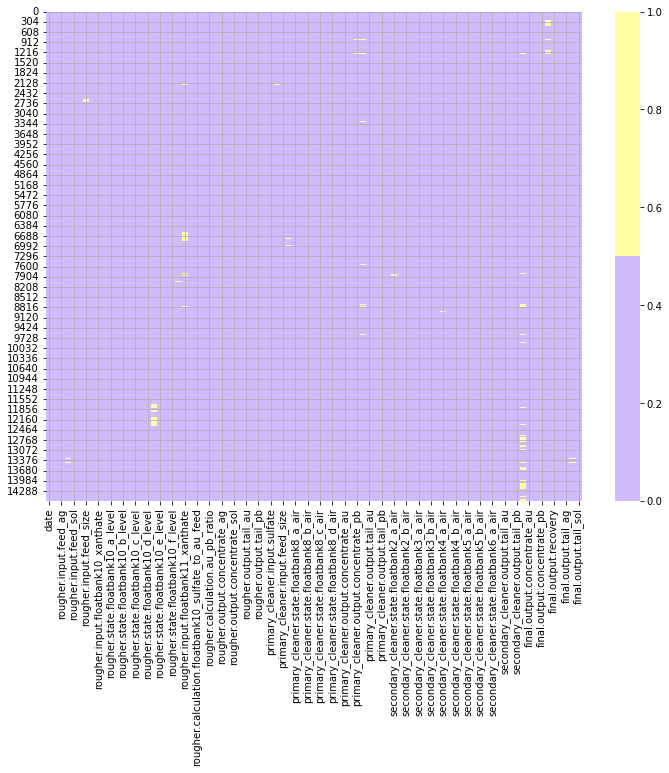

In [7]:
fig, ax = plt.subplots(figsize=(12,9))
print('Пропуски train')
sns.heatmap(train.isnull(), cmap=sns.color_palette(colours))
plt.grid()
train.isna().sum() 

Пропуски test


date                                            0
rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0


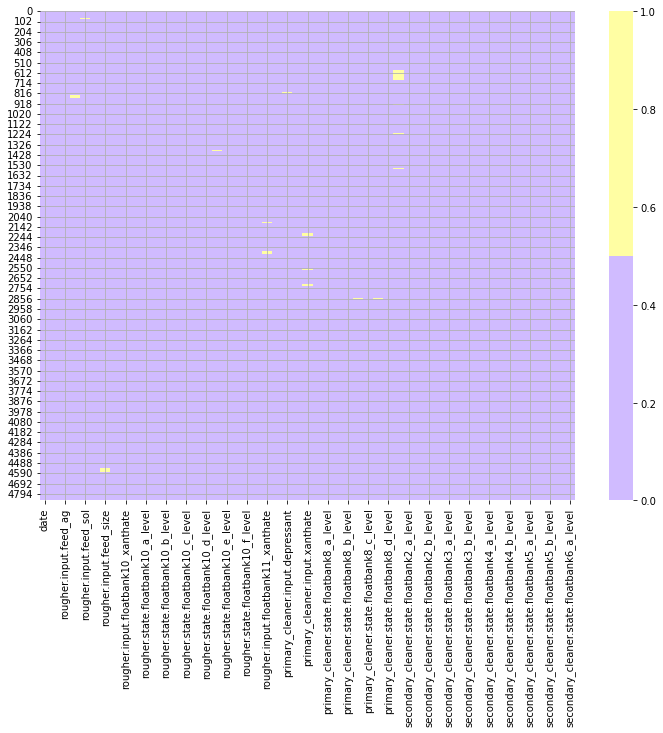

In [8]:
fig, ax = plt.subplots(figsize=(12,9))
print('Пропуски test')
sns.heatmap(test.isnull(), cmap=sns.color_palette(colours))
plt.grid()
test.isna().sum()

In [9]:
# Преобразуем тип данных
full['date'] = full['date'].astype("datetime64[ns]")
train['date'] = train['date'].astype("datetime64[ns]")
test['date'] = test['date'].astype("datetime64[ns]")

In [10]:
# Эффективность обогащения 
train = train.dropna(subset=['rougher.output.recovery','rougher.output.concentrate_au'
                              ,'rougher.input.feed_au','rougher.output.tail_au'])
train['enr_eff'] = ((train['rougher.output.concentrate_au']*(train['rougher.input.feed_au'] - train['rougher.output.tail_au'])
                   )/(train['rougher.input.feed_au']*(train['rougher.output.concentrate_au']-train['rougher.output.tail_au'])))*100



train.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,enr_eff
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297,87.107763
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514,86.843261
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849,86.842308
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835,87.226430
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686,86.688794


In [11]:
train = train.dropna()

In [12]:
# MAE
print('Среднее эфф обогащения исходное', train['rougher.output.recovery'].mean() )
print('MAE:', mean_absolute_error(train['rougher.output.recovery'],train['enr_eff']))

Среднее эфф обогащения исходное 82.99299154061015
MAE: 9.906677443564516e-15


Ошибка стремится к нулю, эффективность обогащения рассчитана верно.

In [13]:
# Каких столбцов не хватает
missing_columns=[]
for i in train.columns:
    if i not in test.columns:
        missing_columns.append(i)
missing_columns = missing_columns[:(len(missing_columns)-1)]        
print('Перечень отсутствующих столбцов:')        
train[missing_columns].info()

Перечень отсутствующих столбцов:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12337 entries, 0 to 14578
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.calculation.sulfate_to_au_concentrate       12337 non-null  float64
 1   rougher.calculation.floatbank10_sulfate_to_au_feed  12337 non-null  float64
 2   rougher.calculation.floatbank11_sulfate_to_au_feed  12337 non-null  float64
 3   rougher.calculation.au_pb_ratio                     12337 non-null  float64
 4   rougher.output.concentrate_au                       12337 non-null  float64
 5   rougher.output.concentrate_ag                       12337 non-null  float64
 6   rougher.output.concentrate_pb                       12337 non-null  float64
 7   rougher.output.concentrate_sol                      12337 non-null  float64
 8   rougher.output.recovery                    

  В списке отсутствующих признаков концентраты и хвосты различных этапов, отсутствуют и целевые признаки `rougher.output.recovery` и  `final.output.recovery`.  Также отсутствуют калькуляции и результаты выходов этапов процесса, т.к. их измерить во время процесса обработки невозможно. В обучающей выборке есть еще ряд неописанных данных `rougher.calculation.sulfate_to_au_concentrate`, `rougher.calculation.floatbank10_sulfate_to_au_feed`, `rougher.calculation.floatbank11_sulfate_to_au_feed`, `rougher.calculation.au_pb_ratio`. Отсутствующие в тестовой выборке признаки признаки имеют отношение к output-параметрам продукта и к последующим calculation-расчётным характеристикам после флотации. Так как тестовая выборка имитирует работу модели в реальных условиях,  использовать отсутствующие признаки в модели нельзя, так как они могут приводить к утечке целевого признака.

In [14]:
# Избавимся от пропусков
test = test.dropna()
test.shape

(4537, 53)

В нашем распоряжении 3 датасета: полная выгрузка, выборка для обучения, тестовая выборка.
Для дальнейшей работы была проведена предобработка данных:
- Была проверена эффективность обогащения путем ручного расчета и сравнения метрики MAE
- В датасет тестовой выборки добавленны отсутствующие столбцы из полной выборки
- Поскольку условием было оговорено, что часть данных недоступны в видоу того, что замеряются и/или рассчитываются значительно позже, то принято решение их не обрабатывать и избавиться от пропусков.

## Анализ данных

In [15]:
def show_concentrate(elem):
    title = "Гистограмма распределения концентрации "+ str(elem).upper()
    rougher_input = 'rougher.input.feed_'+ str(elem)
    #rougher_output = 'rougher.output.concentrate_'+ str(elem)
    primary_cleaner = 'primary_cleaner.output.concentrate_'+ str(elem)
    secondary_cleaner = 'secondary_cleaner.output.tail_'+ str(elem)
    final = 'final.output.tail_'+ str(elem)
    stage_list = [rougher_input, #rougher_output,
                  primary_cleaner, 
                  secondary_cleaner, final]
    
    stage_name = ['rougher_input', #'rougher_output',
                   'primary_cleaner', 
                  'secondary_cleaner', 'final']
    
    new_full = full.dropna(subset = stage_list)
    fig, ax = plt.subplots(figsize=(12,9))
    for i in range(len(stage_list)):
        ax.hist(new_full[stage_list[i]], bins=100, label = stage_name[i], alpha=.5)
        plt.xlabel("Концентрация металла на выходе этапов")
        plt.ylabel("Количество результатов")
        plt.legend(loc='upper right', fontsize='x-large')
        plt.suptitle(title)
        ax.grid(True)
    plt.show()
    display(new_full[stage_list].describe())
    None
    return stage_list
    

In [16]:
def clean_data(columns):
    quantile_20_total=[]
    quantile_95_total=[]
    for i in columns:
        quantile_20= full[i].quantile(0.20)
        quantile_95= full[i].quantile(0.95)
        quantile_20_total.append(quantile_20)
        quantile_95_total.append(quantile_95)
    quantile=pd.DataFrame()
    quantile['quantile_20'] = quantile_20_total
    quantile['quantile_95'] = quantile_95_total
    quantile.index = columns
    return quantile, columns

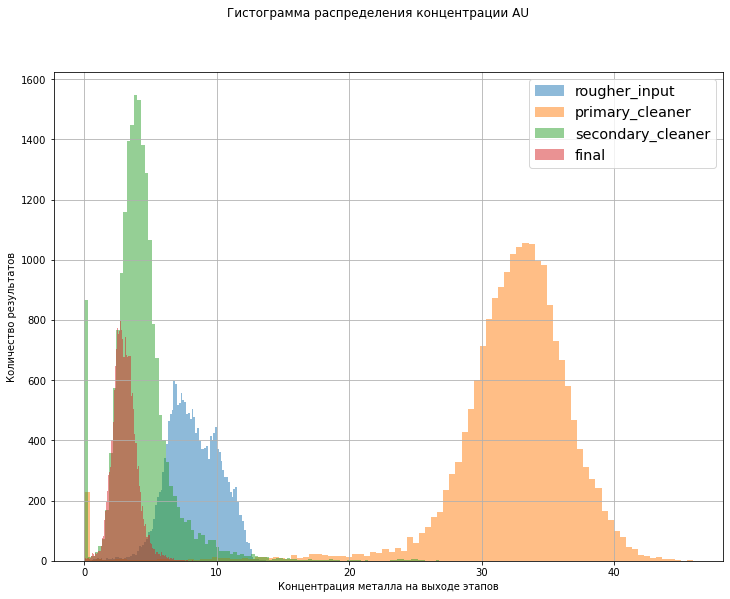

,rougher.input.feed_au,primary_cleaner.output.concentrate_au,secondary_cleaner.output.tail_au,final.output.tail_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.266097,32.119400,4.339625,3.042467
std,1.955092,5.627611,2.326751,0.922808
min,0.010000,0.000000,0.000000,0.000000
25%,6.854384,30.463140,3.182770,2.461138
50%,8.125839,32.841295,4.072412,2.984909
75%,9.769917,35.048006,5.063081,3.571351
max,13.731330,45.933934,26.811643,8.245022


,quantile_20,quantile_95
rougher.input.feed_au,6.609682,11.513648
primary_cleaner.output.concentrate_au,29.841167,38.399505
secondary_cleaner.output.tail_au,2.952840,8.162091
final.output.tail_au,2.344019,4.574940


In [17]:
columns_au = show_concentrate('au')
quantile_au,columns_au= clean_data(columns_au)
quantile_au

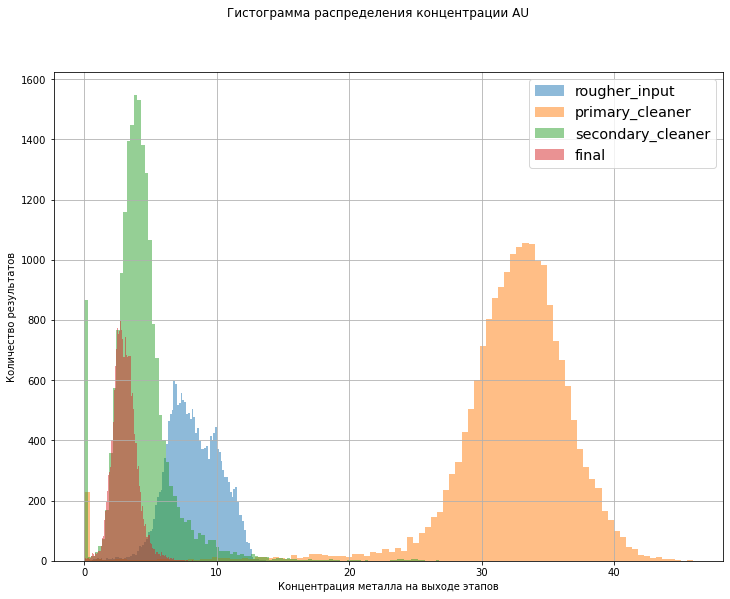

,rougher.input.feed_au,primary_cleaner.output.concentrate_au,secondary_cleaner.output.tail_au,final.output.tail_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.266097,32.119400,4.339625,3.042467
std,1.955092,5.627611,2.326751,0.922808
min,0.010000,0.000000,0.000000,0.000000
25%,6.854384,30.463140,3.182770,2.461138
50%,8.125839,32.841295,4.072412,2.984909
75%,9.769917,35.048006,5.063081,3.571351
max,13.731330,45.933934,26.811643,8.245022


['rougher.input.feed_au',
 'primary_cleaner.output.concentrate_au',
 'secondary_cleaner.output.tail_au',
 'final.output.tail_au']

In [18]:
# Отбрасываем выбросы
for i in columns_au:
    train=train[(train[i]> quantile_au.loc[i]['quantile_20']) & (train[i]<quantile_au.loc[i]['quantile_95'])]
show_concentrate('au')

После построения первой гистограммы стало очевидно, что есть выбросы, которые возможно повлияют на модель впроцессе ее обучения.
Для построена единая функция для всех видов металла, которая обрабатывает данные и удаляет "хвосты".

Гистограмма распределения показывает, что концентрация золота начинает расти на этапе первичной очистки, однако уже на втором уровне очистки концентрация падает и продолжает тенденцию снижения. Возможно это свзано с неполными данными на момент сбора данных.

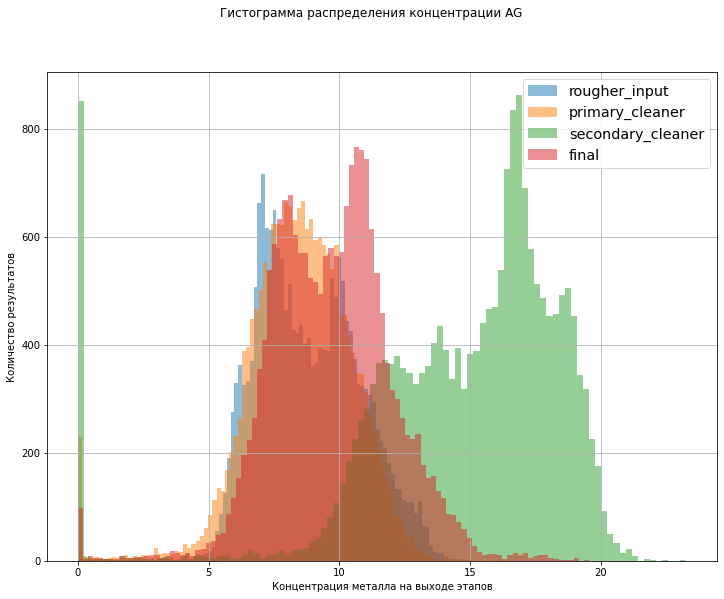

,rougher.input.feed_ag,primary_cleaner.output.concentrate_ag,secondary_cleaner.output.tail_ag,final.output.tail_ag
count,19436.000000,19436.000000,19436.000000,19436.000000
mean,8.795257,8.442798,14.587277,9.689119
std,1.936732,2.053788,4.264863,2.327747
min,0.010000,0.000000,0.000000,0.000000
25%,7.238013,7.263513,12.640418,8.062970
50%,8.593762,8.507349,15.642083,9.744747
75%,10.214230,9.808877,17.358276,11.134353
max,14.596026,16.081632,23.264738,19.552149


,quantile_20,quantile_95
rougher.input.feed_ag,7.030441,12.159041
primary_cleaner.output.concentrate_ag,6.972948,11.489438
secondary_cleaner.output.tail_ag,12.018873,19.286179
final.output.tail_ag,7.770933,13.459533


In [19]:
columns_ag = show_concentrate('ag')
quantile_ag,columns_ag= clean_data(columns_ag)
quantile_ag

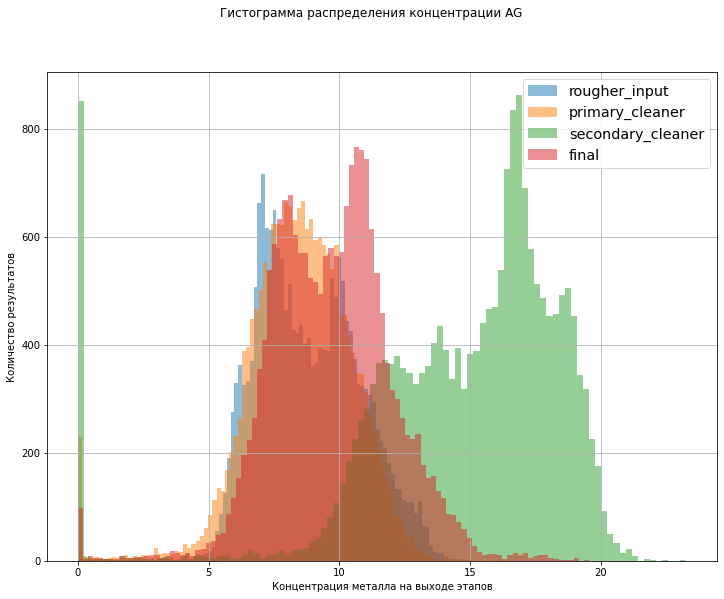

,rougher.input.feed_ag,primary_cleaner.output.concentrate_ag,secondary_cleaner.output.tail_ag,final.output.tail_ag
count,19436.000000,19436.000000,19436.000000,19436.000000
mean,8.795257,8.442798,14.587277,9.689119
std,1.936732,2.053788,4.264863,2.327747
min,0.010000,0.000000,0.000000,0.000000
25%,7.238013,7.263513,12.640418,8.062970
50%,8.593762,8.507349,15.642083,9.744747
75%,10.214230,9.808877,17.358276,11.134353
max,14.596026,16.081632,23.264738,19.552149


['rougher.input.feed_ag',
 'primary_cleaner.output.concentrate_ag',
 'secondary_cleaner.output.tail_ag',
 'final.output.tail_ag']

In [20]:
# Отбрасываем выбросы
for i in columns_ag:
    train=train[(train[i]> quantile_ag.loc[i]['quantile_20']) & (train[i]<quantile_ag.loc[i]['quantile_95'])]
show_concentrate('ag')

Концентрация серебра стабильна на всех этапах кроме второй очистки. После второй очистки концентрация сильно увеличивается, однако к финальному выходу снижается и стремится к исходным данным показателям.

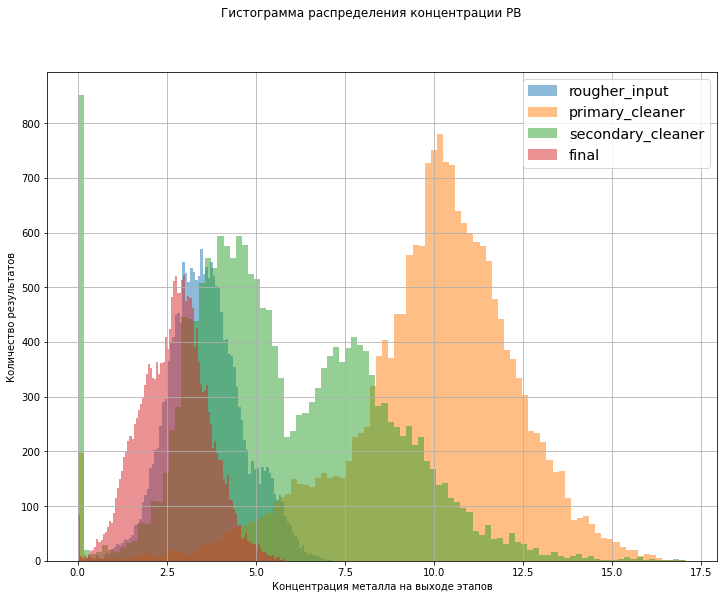

,rougher.input.feed_pb,primary_cleaner.output.concentrate_pb,secondary_cleaner.output.tail_pb,final.output.tail_pb
count,19196.000000,19196.000000,19196.000000,19196.000000
mean,3.605477,9.867153,5.784681,2.711888
std,1.044538,2.509338,2.782833,0.944689
min,0.010000,0.000000,0.000000,0.000000
25%,2.894769,8.740896,3.858802,2.046808
50%,3.541339,10.164723,5.346885,2.752726
75%,4.250211,11.432459,7.805403,3.335794
max,7.142594,17.081278,17.042505,5.804178


,quantile_20,quantile_95
rougher.input.feed_pb,2.731387,5.491104
primary_cleaner.output.concentrate_pb,8.272009,13.372056
secondary_cleaner.output.tail_pb,3.552266,10.404390
final.output.tail_pb,1.877651,4.241309


In [21]:
columns_pb = show_concentrate('pb')
quantile_pb,columns_pb= clean_data(columns_pb)
quantile_pb

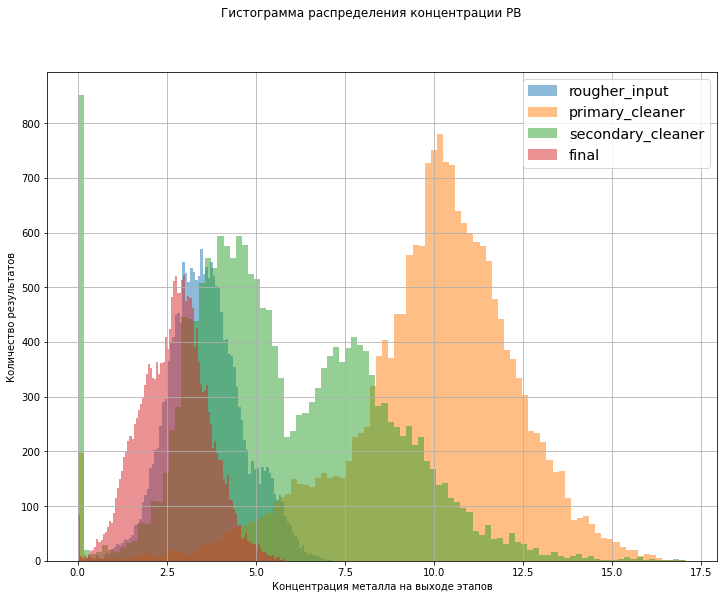

,rougher.input.feed_pb,primary_cleaner.output.concentrate_pb,secondary_cleaner.output.tail_pb,final.output.tail_pb
count,19196.000000,19196.000000,19196.000000,19196.000000
mean,3.605477,9.867153,5.784681,2.711888
std,1.044538,2.509338,2.782833,0.944689
min,0.010000,0.000000,0.000000,0.000000
25%,2.894769,8.740896,3.858802,2.046808
50%,3.541339,10.164723,5.346885,2.752726
75%,4.250211,11.432459,7.805403,3.335794
max,7.142594,17.081278,17.042505,5.804178


['rougher.input.feed_pb',
 'primary_cleaner.output.concentrate_pb',
 'secondary_cleaner.output.tail_pb',
 'final.output.tail_pb']

In [22]:
# Отбрасываем выбросы
for i in columns_pb:
    train=train[(train[i]> quantile_pb.loc[i]['quantile_20']) & (train[i]<quantile_pb.loc[i]['quantile_95'])]
show_concentrate('pb')

Рисунок концентрации свинца логичен. Концентрация на каждом этапе увеличивается, однако к финишу существенно снижается..

После построения первой гистограммы стало очевидно, что есть выбросы, которые возможно повлияют на модель впроцессе ее обучения.
Для построена единая функция для всех видов металла, которая обрабатывает данные и удаляет "хвосты".

Гистограмма распределения показывает, что концентрация золота растет на каждом этапе, однако на финише концентрация падает.
Возможно это свзано с неполными данными на момент сбора данных.

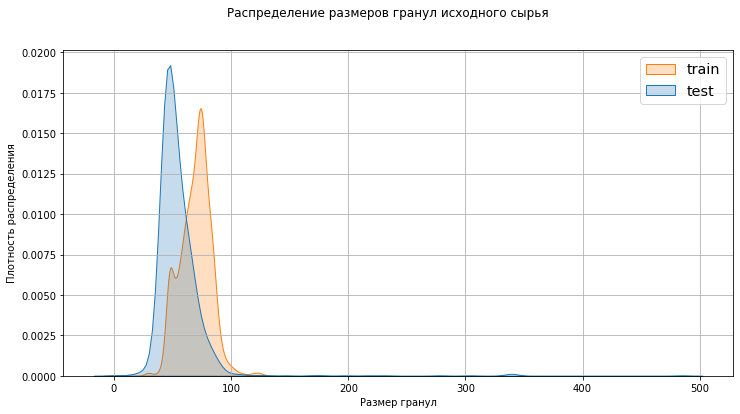

In [23]:
df_kde = train[['rougher.input.feed_size']].reset_index(drop=True)
df_kde['test'] = test['rougher.input.feed_size']
df_kde.columns = ['train','test']
fig,ax  = plt.subplots(figsize=(12,6))
sns.kdeplot(data = df_kde, ax=ax, fill=True)
ax.set_ylabel("Плотность распределения")
ax.set_xlabel("Размер гранул")
plt.suptitle('Распределение размеров гранул исходного сырья')
plt.legend(df_kde, loc='upper right', fontsize='x-large')
plt.grid(True)


- Проверена тестовая и обучающая выборка на соответствие распределения размеров гранул исходного сырья. Для проверки использовалась гистограмма, на которой видна тенденция повторения контуров распределения, которые отличаются масштабом и котрастностью перепадов, что в свою очередь скорее всего зависит от количества данных в тестовой выборке(их мало). Также проведена обработка данных на предмет выбросов.

In [24]:
# Избавимся от выбросов в размерах гранул исходного сырья
quantile_20 = train['rougher.input.feed_size'].quantile(0.20)
quantile_95= train['rougher.input.feed_size'].quantile(0.95)

train = train[(train['rougher.input.feed_size']>quantile_20) &  (train['rougher.input.feed_size']<quantile_95)]
test = test[(test['rougher.input.feed_size']>quantile_20) &  (test['rougher.input.feed_size']<quantile_95)]

In [25]:
def graph_var1(df_kde):
    fig,ax  = plt.subplots(figsize=(12,6))
    sns.kdeplot(data = df_kde, ax=ax, fill=True)
    ax.set_ylabel("Суммарная концентрация металловя")
    ax.set_xlabel("Концентрация металов на выходе этапов")
    plt.suptitle('Гистограмма распределения суммарной концентрации металлов металлов по этапам')
    plt.legend(df_kde, loc='upper left', fontsize='x-large')
    plt.grid(True)

In [26]:
column_names = ['rougher.input.feed', 'rougher.output.concentrate', 
                    'primary_cleaner.output.concentrate', 'secondary_cleaner.output.tail','final.output.concentrate']
 
def columns(column):  
    column_1 = column + str('_au')
    column_2 = column + str('_ag')
    column_3 = column + str('_pb')
    return column_1, column_2, column_3

In [27]:
def concentrate_totral_1(data):
    new_full = data.dropna()
    
    
    for i in column_names:
        column_1, column_2, column_3 = columns(i)
        new_full[i] = (new_full[column_1] + new_full[column_2] + new_full[column_3])

    new_full = new_full[column_names]
    
    graph_var1(new_full)

На примере полной выборки


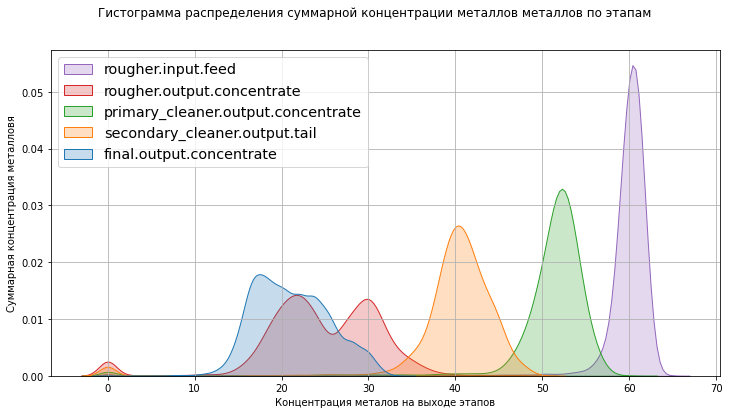

In [28]:
print('На примере полной выборки')
concentrate_totral_1(full)

На примере обучающей выборки


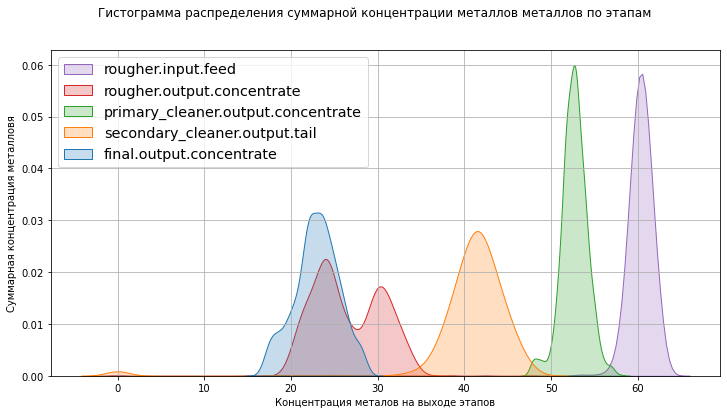

In [29]:
print('На примере обучающей выборки')
concentrate_totral_1(train)

В рамках анализа были проведены следующие исследовани:
- Построены гистограммы распределения концентраций поэтапу обработки и типу металла. Графики показали стостаточное количество выбросов и аномалий, что в конечном итоге может сильно отразиться на качестве модели. Уход от выбросов был произведен методом отсекания по квантилям.
- Проверена тестовая и обучающая выборка на соответствие распределения размеров гранул исходного сырья. Для проверки использовалась гистограмма, на которой видна тенденция повторения контуров распределения, которые отличаются масштабом и котрастностью перепадов. Также проведена обработка данных на предмет выбросов.
- Суммакрная концентрация полной выборки выглядит логично по отношению к технологическому процессу. У обучающей выборки "проседают" показатели финишной очистки. Возможно стоит более тщательно отбирать данные для обучающей выборки.

## Модель

In [30]:
def sMAPE(y_true,y_pred):
    error = np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100
    return error

In [31]:
def final_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

In [32]:
features_test = test.drop(['date'], axis = 1).reset_index(drop=True)
target_test = test.merge(full[['date','rougher.output.recovery', 'final.output.recovery']], on= 'date', how = 'left')
target_test = target_test[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)

In [33]:
target_train = train[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)

features_train = train[features_test.columns].reset_index(drop=True)


In [34]:
print(target_test.shape)
print(features_test.shape)

(3646, 2)
(3646, 52)


In [35]:
print(target_train.shape)
print(features_train.shape)

(1306, 2)
(1306, 52)


In [36]:
def grid_fit(model, column, features_train=features_train, get_best_params=False):

    
    model.fit(features_train, target_train[column])
    best_params = model.best_params_
    smape = model.best_score_
    
    if get_best_params:
        return model, best_params, -smape
    else:
        return model, -smape

In [37]:
custom_score = make_scorer(sMAPE,greater_is_better=False)

In [38]:
# список,  моделей
models_list = []

# Модель Дерево решений


start_time = time.time()
model_class_dt = DecisionTreeRegressor()
parametrs = { 'max_depth': range(1,12),
              'min_samples_leaf': range(1,10),
              'min_samples_split': range(2,10) 
            }

grid_dt = GridSearchCV(model_class_dt, parametrs, scoring=custom_score, cv=7, n_jobs =-1)


DT_model_rougher, rougher_best_params, sMAPE_rougher = grid_fit(grid_dt,
                                                                'rougher.output.recovery', 
                                                                get_best_params=True)
DT_model_final, final_best_params, sMAPE_final = grid_fit(grid_dt,
                                                          'final.output.recovery', 
                                                          get_best_params=True)
# собираем обученные модели в список
models_list.append(DT_model_rougher)
models_list.append(DT_model_final)

total_dt = final_sMAPE(sMAPE_rougher, sMAPE_final)

finish_time = time.time() 

print ("Расчетное время", finish_time-start_time)
print("Лучшие параметры модели для данных rougher:", rougher_best_params)
print("Лучшие параметры модели для данных final:", final_best_params)

print("Итоговое SMAPE:", total_dt, "\n")

Расчетное время 309.6211919784546
Лучшие параметры модели для данных rougher: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 9}
Лучшие параметры модели для данных final: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 7}
Итоговое SMAPE: 6.060815399224107 



In [39]:
start_time = time.time()

#Проверка модели Случайного леса
model_class_rf = RandomForestRegressor()
parametrs = { 'n_estimators': range (1, 12),
              'max_depth': range (1,12),
              'min_samples_leaf': range (1,10),
              'min_samples_split': range (2,10)
            }

grid_rf = GridSearchCV(model_class_rf, parametrs, scoring=custom_score, cv=7, n_jobs=-1)

RF_model_rougher, rougher_best_params, sMAPE_rougher = grid_fit(grid_rf,
                                                                'rougher.output.recovery', 
                                                                get_best_params=True)
RF_model_final, final_best_params, sMAPE_final = grid_fit(grid_rf,
                                                          'final.output.recovery', 
                                                          get_best_params=True)
# собираем обученные модели в список
models_list.append(RF_model_rougher)
models_list.append(RF_model_final)

total_rf = final_sMAPE(sMAPE_rougher, sMAPE_final)

finish_time = time.time() 

print ("Расчетное время", finish_time-start_time)
print("Лучшие параметры модели для данных rougher:", rougher_best_params)
print("Лучшие параметры модели для данных final:", final_best_params)

print("Итоговое SMAPE:", total_rf, "\n")

Расчетное время 9843.780462026596
Лучшие параметры модели для данных rougher: {'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 2}
Лучшие параметры модели для данных final: {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 9}
Итоговое SMAPE: 5.751816252206902 



In [40]:
# Константная модель
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)
dummy_predict = pd.DataFrame(dummy_model.predict(features_test), columns=target_train.columns)

In [41]:
def grid_fit_2(model, column, target_test=target_test,dummy_predict=dummy_predict):

    
    model.fit(features_test, target_test[column])
    smape = sMAPE(target_test[column], dummy_predict[column])
    
    return model, abs(smape)

In [42]:
DM_dummy_model, dummy_sMAPE_rougher = grid_fit_2(dummy_model,'rougher.output.recovery')

DM_dummy_model, dummy_sMAPE_final = grid_fit_2(dummy_model,'final.output.recovery')


total_dm = final_sMAPE(dummy_sMAPE_rougher, dummy_sMAPE_final)

print("Итоговое SMAPE:", total_dm, "\n") 

Итоговое SMAPE: 8.332317465435814 



In [43]:
if total_dt <= total_rf:
    models_list[0].fit(features_train, target_train['rougher.output.recovery'])
    smape_rougher_output_recovery = sMAPE(target_test['rougher.output.recovery'],
                                       models_list[0].predict(features_test))
    
    models_list[1].fit(features_train, target_train['final.output.recovery'])
    smape_final_output_recovery = sMAPE(target_test['final.output.recovery'],
                                       models_list[1].predict(features_test))

else:  
    models_list[2].fit(features_train, target_train['rougher.output.recovery'])
    smape_rougher_output_recovery = sMAPE(target_test['rougher.output.recovery'],
                                       models_list[2].predict(features_test))
    
    models_list[3].fit(features_train, target_train['final.output.recovery'])
    smape_final_output_recovery = sMAPE(target_test['final.output.recovery'],
                                       models_list[3].predict(features_test))

final_smape_for_test = final_sMAPE(smape_rougher_output_recovery, smape_final_output_recovery)

print("Итоговое SMAPE:", final_smape_for_test, "\n")

Итоговое SMAPE: 8.272786456025061 



Было проверено обучено 2 модели: 

- дерево решений 

final_sMAPE: 6.0608153992240997

Расчетное время 46.92377328872681

- случайный лес

final_sMAPE: 5.569425111959397 

Расчетное время  1742.463904619217


Лучшей при подборе параметров оказалась модель случайного леса, однако дерево решений отстает на 0.5 показателя final_sMAPE и расчитывается намного быстрее своего конкурента.

Константная модель создавалась на DummyRegressor. Проверка модели на тестовой выборке дает final_sMAPE 8.332317465435814 .

Тестирование модели Случайного леса показывает final_sMAPE 8.056147398110394, что однозначно ниже константной, а значит и  эффективность обученной модели доказана.